In [77]:
import re
import random
import pandas as pd
import hashlib

In [78]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [79]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
WSL + Kali Linux,308.077305,61.615461,100.059770,5
VMWare,476.503963,11.081488,32.534401,43
C# Basics,817.711370,26.377786,74.743197,31
Azure Private DNS,904.356910,47.597732,115.191824,19
Logging in Python,958.482700,68.463050,218.210558,14
Azure Compute Gallery,1064.467810,26.611695,97.692052,40
Azure AD Authentication,1065.547727,81.965210,250.200523,13
Azure Functions + Visual Studio,1112.763516,85.597194,186.653625,13
Email Auth and Security,1151.810360,95.984197,251.376332,12
RAG Project,1281.778349,80.111147,211.915110,16


# Histogram

sum of ages: ~49617.62


<Axes: >

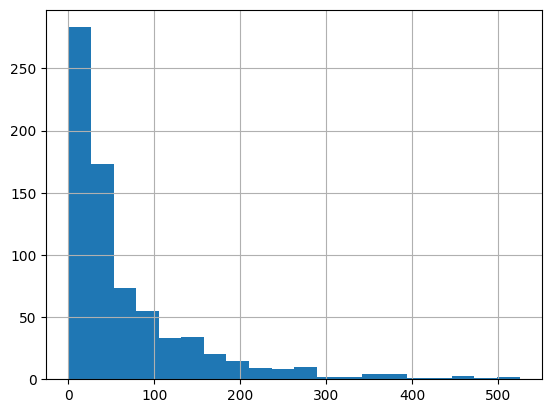

In [80]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [81]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [82]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 733
Total card age: 49617.62


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
621,Vocab,Grapheme\nnoun\nSPA: GRAP-heem\nIPA: /ˈɡræfiːm...,8f4fc671f33b822f1aea884b8bc5888a,524.673657,53.555257,524.673657,5998.188756,0.461174
293,Python,Q:\nWhich keyword is used to define a generato...,f7dc92b45b9a788daad8519bc3a409c8,523.314414,103.801004,523.314414,3944.438140,0.854007
5,Audit Report Tracker (Sharepoint List),View (SharePoint View)\nDefinition: A pre-defi...,c9375efcef5b15bae0f26f4f8d80a3f7,495.783208,153.689920,495.783208,1690.589122,0.127043
460,Azure Developer Associate,"In a multitenant Entra ID app, how many applic...",9810ab85f6e08995290955ede17f4e88,453.479919,97.025315,453.479919,4754.240426,0.063001
6,Audit Report Tracker (Sharepoint List),List Columns Endpoint (for getting column info...,3bd5c040a578b34b790adce8588c4036,452.233313,153.689920,495.783208,1690.589122,0.127043
509,JavaScript Concepts,Hot Module Replacement (HMR): A feature in bun...,62eed610b799097eb68b6e656481e34c,450.915781,118.511981,450.915781,6162.623021,0.830489
120,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,438.289100,81.055317,438.289100,1702.161666,0.202090
510,JavaScript Concepts,Spread and Rest Operators (...): Operators tha...,c6d7508de1e7714c70e2314c3435af41,408.885339,118.511981,450.915781,6162.623021,0.830489
511,JavaScript Concepts,Switch Statement\nswitch (expression) {\n c...,640dd8e068d96778d3079d9a38f3175a,380.162514,118.511981,450.915781,6162.623021,0.830489
561,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,370.550417,69.448982,370.550417,4166.938912,0.101647


# Headers with fewest notes first

In [83]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [84]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [85]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [86]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [87]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [88]:
# n=10
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [89]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [90]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [91]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [92]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [93]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
621,Vocab,Grapheme\nnoun\nSPA: GRAP-heem\nIPA: /ˈɡræfiːm...,8f4fc671f33b822f1aea884b8bc5888a,524.673657,53.555257,524.673657,5998.188756,0.461174
293,Python,Q:\nWhich keyword is used to define a generato...,f7dc92b45b9a788daad8519bc3a409c8,523.314414,103.801004,523.314414,3944.438140,0.854007
5,Audit Report Tracker (Sharepoint List),View (SharePoint View)\nDefinition: A pre-defi...,c9375efcef5b15bae0f26f4f8d80a3f7,495.783208,153.689920,495.783208,1690.589122,0.127043
460,Azure Developer Associate,"In a multitenant Entra ID app, how many applic...",9810ab85f6e08995290955ede17f4e88,453.479919,97.025315,453.479919,4754.240426,0.063001
6,Audit Report Tracker (Sharepoint List),List Columns Endpoint (for getting column info...,3bd5c040a578b34b790adce8588c4036,452.233313,153.689920,495.783208,1690.589122,0.127043
509,JavaScript Concepts,Hot Module Replacement (HMR): A feature in bun...,62eed610b799097eb68b6e656481e34c,450.915781,118.511981,450.915781,6162.623021,0.830489
120,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,438.289100,81.055317,438.289100,1702.161666,0.202090
510,JavaScript Concepts,Spread and Rest Operators (...): Operators tha...,c6d7508de1e7714c70e2314c3435af41,408.885339,118.511981,450.915781,6162.623021,0.830489
511,JavaScript Concepts,Switch Statement\nswitch (expression) {\n c...,640dd8e068d96778d3079d9a38f3175a,380.162514,118.511981,450.915781,6162.623021,0.830489
561,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,370.550417,69.448982,370.550417,4166.938912,0.101647


In [94]:
existing_cards.head(10).sum()

head                   VocabPythonAudit Report Tracker (Sharepoint Li...
body                   Grapheme\nnoun\nSPA: GRAP-heem\nIPA: /ˈɡræfiːm...
hash                   8f4fc671f33b822f1aea884b8bc5888af7dc92b45b9a78...
age                                                          4498.287661
subject_mean_age                                             1067.801658
subject_highest_age                                          4654.621265
subject_age_sum                                             42435.015204
head_random_roll                                                4.427472
dtype: object

In [95]:
existing_cards['age'].mean()

67.69116036798249